# <div style="text-align: center"> Residency Choice in the Puget Sound Region </div>

## <div style="text-align: center"> Executive Summary </div>



 <div style="text-align: center"> Geoffrey Gund </div> 
 <div style="text-align: center">Evans School of Public Policy and Governance  </div> 
 <div style="text-align: center">University of Washington  </div> 
 <div style="text-align: center">Seattle, WA 98195</div> 
 <div style="text-align: center">March 13, 2017</div> 
 ***

In [21]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>Note: the raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</i>''')

In [7]:
import os
import xlrd
import pandas as pd
from pandas.api.types import CategoricalDtype
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot
folderData="https://rawgit.com/geeoffgoond/project/master/"
fileXL=os.path.join(folderData,"2015-pr1-hhsurvey-household.xlsx")
psrchh=pd.read_excel(fileXL) #titled 'psrchh' because it's the Puget Sound Regional Council Household Data
psrchh=psrchh[["hhid", "hhnumtrips", "hh_income_detailed", "h_zip", "h_city", "res_factors_hhchange", "res_factors_afford", "res_factors_school", "res_factors_walk", "res_factors_space", "res_factors_closefam", "res_factors_transit", "res_factors_hwy", "res_factors_30min", "prev_home_loc_zip", "prev_home_loc_city", "prev_home_loc_st"]]
fileZips=os.path.join(folderData,"waStateZips.xlsx") #getting an excel file with WA state zips by county
waStateZips=pd.read_excel(fileZips) 
PugetSoundCounties = ["KING", "KITSAP", "PIERCE", "SNOHOMISH", "ISLANDS"] #can change
psZips = waStateZips[(waStateZips['County Name']).isin(PugetSoundCounties)] #creates a dataFrame of data from those counties
psZips.reset_index(inplace=True,drop=True) # resetting the index
psrchh = psrchh[(psrchh["h_zip"]).isin(psZips.zip)] #restricting our dataset to just those zipcodes in the counties we specified
resfacNames=psrchh.columns[psrchh.columns.str.contains('res_factors')].tolist()
psMove = psrchh.groupby(['h_zip'], as_index=False)[resfacNames].mean()
psMove['factor1'] = psMove[['res_factors_hhchange',
 'res_factors_afford',
 'res_factors_school',
 'res_factors_walk',
 'res_factors_space',
 'res_factors_closefam',
 'res_factors_transit',
 'res_factors_hwy',
 'res_factors_30min']].idxmax(axis=1) #idmax identifies the maximum value in each row and returns the name of the colmun it is in
psMove.factor1=psMove.factor1.astype(CategoricalDtype(categories=resfacNames, 
                                         ordered=True))
compressedMap=os.path.join(folderData,'WaZipsMap.zip') #setting the map filepath
waZipMap = gpd.GeoDataFrame.from_file(compressedMap)
waZipMap.ZCTA5CE10=waZipMap.ZCTA5CE10.astype(int) #setting to int
waZipMap=waZipMap[(waZipMap.ZCTA5CE10.isin(psZips.zip))]
psMoveMap=waZipMap.merge(psMove, left_on='ZCTA5CE10', right_on='h_zip') ## merging data into shapefile

## 1. Introduction

In this project I explore reasons why people choose to live where they live in the Puget Sound Region.

## 2. Dataset

The data come from the 2015 Puget Sound Regional Council Travel Household Study. This study gathers information about how, why, and when people in the Puget Sound Region travel, and includes information on where they live, their household composition, their income, and why they choose to live where they do. 

The data and documentation are available from the [Puget Sound Regional Council](https://www.psrc.org/household-travel-survey-program), as well as in this github repository.

## 3. Variables

The variables of interest include:
1.    **Home Zip Code**: The zipcode in which the study participant resides.

2.    **Residential Factors**: A collection of the following 9 variables, each rated on 1-5 scale by respondents in terms of impact on their choice to live where they live:
        * change in household composition
        * affordability
        * school quality 
        * walkability
        * space
        * proximity to family
        * access to transit
        * access to highways
        * 30 minute or less commute time

## 4. Why People in the Puget Sound Region Move:

Exploring the data shows that affordability is the greatest factor overall, and the greatest factor in most zip codes.

### Means & Barplot:

res_factors_hhchange    2.695616
res_factors_afford      4.309347
res_factors_school      2.776675
res_factors_walk        4.032672
res_factors_space       3.541356
res_factors_closefam    3.355252
res_factors_transit     3.436311
res_factors_hwy         3.114144
res_factors_30min       3.774607
dtype: float64

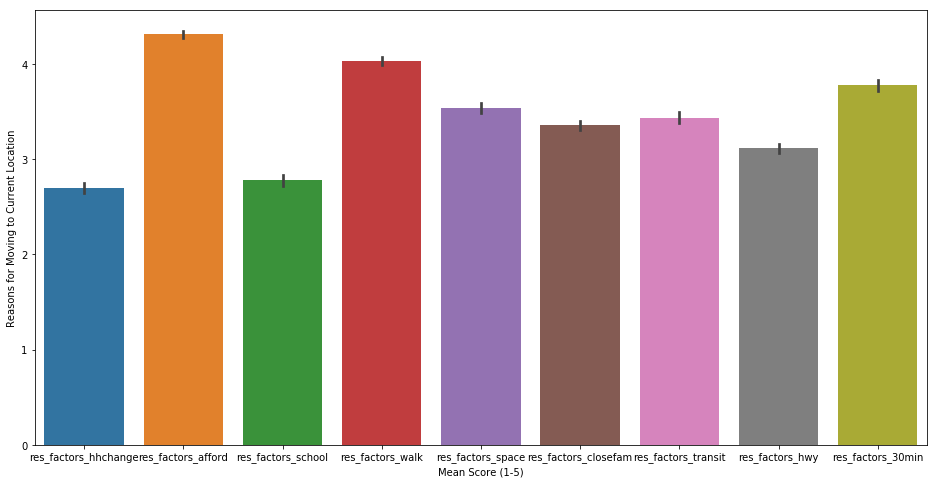

In [11]:
%matplotlib inline
dims = (16, 8) #setting dimensions
df = psrchh[resfacNames] #setting dataframe
fig, ax = pyplot.subplots(figsize=dims)
ax.set(xlabel = 'Mean Score (1-5)', ylabel = 'Reasons for Moving to Current Location')
#sns.barplot(ax=ax, data=df)
psrchh[resfacNames].mean()

As the barplot shows, "res factors afford" has the highest mean score. Here is a table with the means:

| Factor        | Mean Score    | 
| ------------- |:-------------:| 
| change in houshold composition      | 2.7 | 
| affordability      | 4.3      |  
| school quality | 2.8     |  
| walkability | 4.0 |
| space | 3.5 | 
| proximity to family | 3.4 |
| access to transit | 3.4 |
| access to highways | 3.1 |
| 30 min or less commute | 3.8 |

### Maps

Here is a map showing the highest average Residential Factor for each zip code in our dataset:

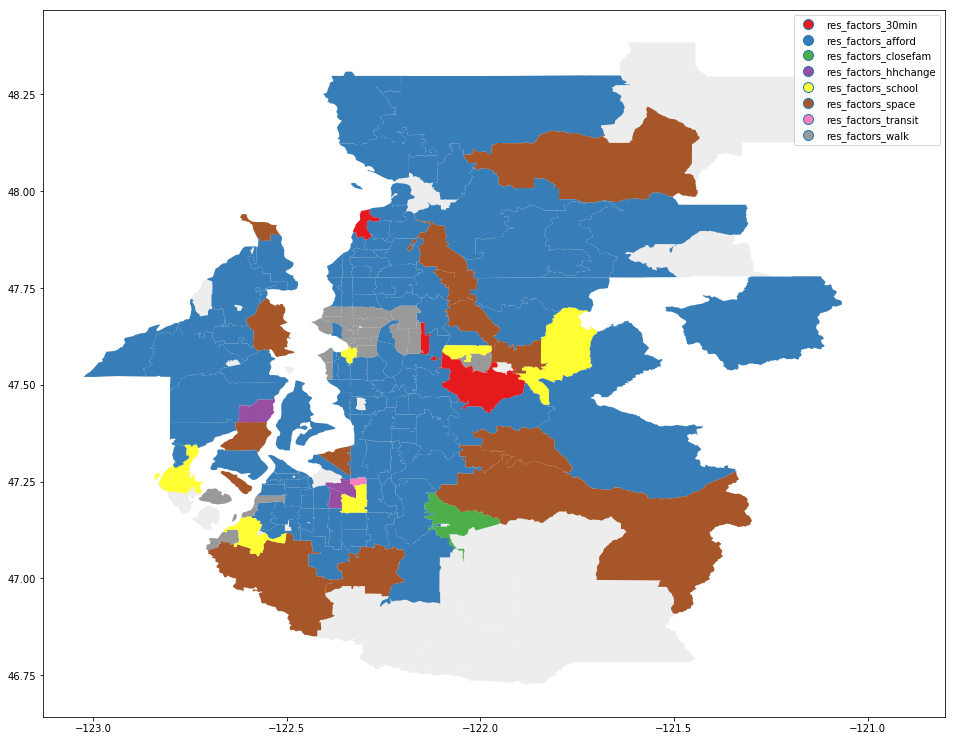

In [12]:
%matplotlib inline
base = waZipMap.plot(color='#ededed',figsize=(20,13)) #setting specifications for the map
psMoveMap.plot(ax=base,column='factor1',cmap='Set1',categorical=True,legend=True) #plotting factor1


Here is a map showing the the score of highest average Residential Factor, Affordability, in each zip code:

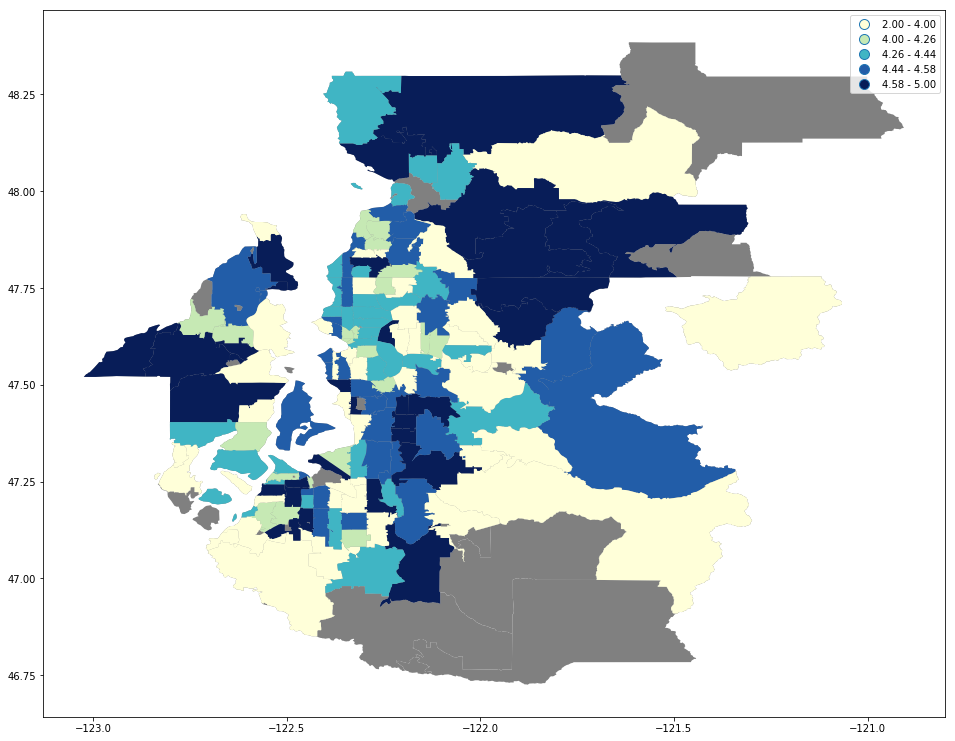

In [13]:
%matplotlib inline
base = waZipMap.plot(color='grey',figsize=(20,13))
psMoveMap.plot(ax=base,column='res_factors_afford', cmap='YlGnBu', scheme='Quantiles', k=5, legend=True) #affordability